In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7410639482389068391, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9214062756
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16374923066512124775
 physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [3]:
import sys
import time
import math
import os
import pandas as pd
import numpy as np

import keras
from keras import layers, metrics, models, optimizers
from keras.optimizers import Adam, RMSprop,SGD
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, concatenate, Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
import keras
import tensorflow as tf

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
# print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0


In [5]:
batch_size = 16
img_rows, img_cols = 512, 512
input_shape = (img_rows, img_cols, 3)
epochs = 150

In [6]:
train_dir = 'data_augmented/cvc300_train/'
validation_dir = 'data_augmented/cvc300_validation/'
test_dir = 'data_augmented/cvc300_test/'

image_folder = 'images'
masks_folder = 'masks'

In [7]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((img_rows, img_cols, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [8]:
seed = 1142
data_gen_args = dict(rescale=1. / 255, featurewise_center=True, featurewise_std_normalization=True)
image_datagen = ImageDataGenerator(**data_gen_args)
masks_datagen = ImageDataGenerator(**data_gen_args)

test_datagen = ImageDataGenerator(rescale=1./255)

image_generator = image_datagen.flow_from_directory(
    train_dir,
    classes = [image_folder],
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

mask_generator = masks_datagen.flow_from_directory(
    train_dir,
    classes = [masks_folder],
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

validation_image_generator = image_datagen.flow_from_directory(
    validation_dir,
    classes = [image_folder],
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

validation_mask_generator = masks_datagen.flow_from_directory(
    validation_dir,
    classes = [masks_folder],
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

test_image_generator = test_datagen.flow_from_directory(
    test_dir,
    classes = [image_folder],
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

test_mask_generator = test_datagen.flow_from_directory(
    test_dir,
    classes = [masks_folder],
    color_mode='grayscale',
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode=None,
    seed=seed)

Found 26112 images belonging to 1 classes.
Found 26112 images belonging to 1 classes.
Found 8704 images belonging to 1 classes.
Found 8704 images belonging to 1 classes.
Found 28 images belonging to 1 classes.
Found 28 images belonging to 1 classes.


In [9]:
train_generator = zip(image_generator, mask_generator)
validation_generator = zip(validation_image_generator, validation_mask_generator)
test_generator = zip(test_image_generator, test_mask_generator)

In [10]:
nb_train_samples = len(image_generator.filenames)
nb_validation_samples = len(validation_image_generator.filenames)
nb_test_samples = len(test_image_generator.filenames)

predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("nb_test_samples:", nb_test_samples)

print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
print("predict_size_test:", predict_size_test)

nb_train_samples: 26112
nb_validation_samples: 8704
nb_test_samples: 28

predict_size_train: 1632
predict_size_validation: 544
predict_size_test: 2


In [11]:
smooth = 1.
from keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def Specificity(y_true, y_pred):
    true_negatives = K.abs(y_pred)- K.abs(y_true)
    return ((true_negatives+smooth)/(y_pred+ smooth))

def Sensitivity(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return ((y_pred+smooth)/ (y_true+smooth))

def Jaccard_index(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall))

In [12]:
model = UNet()
model.summary()
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer= adam_opt, loss=dice_coef_loss, 
              metrics=[dice_coef, 'acc','mse', Jaccard_index, Specificity, Sensitivity, precision, recall, f1score])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 16) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [13]:
history = model.fit_generator(train_generator,
                    steps_per_epoch=nb_train_samples//batch_size,
                    epochs=epochs,
                    validation_data = validation_generator,
                    validation_steps = nb_validation_samples//batch_size)

Epoch 1/150
1632/1632 [==============================] - 752s 461ms/step - loss: -0.0711 - dice_coef: 0.0711 - acc: 0.4973 - mean_squared_error: 0.3114 - Jaccard_index: 0.0378 - Specificity: 0.9647 - Sensitivity: 1.3228 - precision: 0.0403 - recall: 0.4540 - f1score: nan - val_loss: -0.1775 - val_dice_coef: 0.1775 - val_acc: 0.5064 - val_mean_squared_error: 0.3701 - val_Jaccard_index: 0.0979 - val_Specificity: 0.9643 - val_Sensitivity: 1.3618 - val_precision: 0.1133 - val_recall: 0.7461 - val_f1score: 0.1957
Epoch 2/150
1632/1632 [==============================] - 748s 459ms/step - loss: -0.1639 - dice_coef: 0.1639 - acc: 0.5941 - mean_squared_error: 0.2760 - Jaccard_index: 0.0897 - Specificity: 0.9678 - Sensitivity: 1.2613 - precision: 0.1052 - recall: 0.6114 - f1score: 0.1773 - val_loss: -0.2176 - val_dice_coef: 0.2176 - val_acc: 0.6460 - val_mean_squared_error: 0.2170 - val_Jaccard_index: 0.1233 - val_Specificity: 0.9596 - val_Sensitivity: 1.1923 - val_precision: 0.1489 - val_recall

Epoch 17/150
1632/1632 [==============================] - 759s 465ms/step - loss: -0.7152 - dice_coef: 0.7152 - acc: 0.8304 - mean_squared_error: 0.0184 - Jaccard_index: 0.5586 - Specificity: 0.9702 - Sensitivity: 1.0031 - precision: 0.8269 - recall: 0.7219 - f1score: 0.7664 - val_loss: -0.6380 - val_dice_coef: 0.6380 - val_acc: 0.8230 - val_mean_squared_error: 0.0268 - val_Jaccard_index: 0.4718 - val_Specificity: 0.9592 - val_Sensitivity: 0.9945 - val_precision: 0.8446 - val_recall: 0.5663 - val_f1score: 0.6751
Epoch 18/150
1632/1632 [==============================] - 758s 464ms/step - loss: -0.7309 - dice_coef: 0.7309 - acc: 0.8312 - mean_squared_error: 0.0171 - Jaccard_index: 0.5780 - Specificity: 0.9706 - Sensitivity: 1.0029 - precision: 0.8410 - recall: 0.7403 - f1score: 0.7838 - val_loss: -0.6595 - val_dice_coef: 0.6595 - val_acc: 0.8200 - val_mean_squared_error: 0.0276 - val_Jaccard_index: 0.4949 - val_Specificity: 0.9613 - val_Sensitivity: 1.0020 - val_precision: 0.7832 - val_r

Epoch 33/150
1632/1632 [==============================] - 754s 462ms/step - loss: -0.8378 - dice_coef: 0.8378 - acc: 0.8364 - mean_squared_error: 0.0089 - Jaccard_index: 0.7219 - Specificity: 0.9735 - Sensitivity: 1.0026 - precision: 0.9300 - recall: 0.8792 - f1score: 0.9032 - val_loss: -0.7058 - val_dice_coef: 0.7058 - val_acc: 0.8242 - val_mean_squared_error: 0.0230 - val_Jaccard_index: 0.5487 - val_Specificity: 0.9618 - val_Sensitivity: 0.9979 - val_precision: 0.8692 - val_recall: 0.6747 - val_f1score: 0.7566
Epoch 34/150
1632/1632 [==============================] - 754s 462ms/step - loss: -0.8402 - dice_coef: 0.8402 - acc: 0.8365 - mean_squared_error: 0.0088 - Jaccard_index: 0.7255 - Specificity: 0.9736 - Sensitivity: 1.0027 - precision: 0.9317 - recall: 0.8828 - f1score: 0.9059 - val_loss: -0.0832 - val_dice_coef: 0.0832 - val_acc: 0.7827 - val_mean_squared_error: 0.0866 - val_Jaccard_index: 0.0440 - val_Specificity: 0.9453 - val_Sensitivity: 1.0133 - val_precision: 0.1048 - val_r

Epoch 49/150
1632/1632 [==============================] - 754s 462ms/step - loss: -0.8727 - dice_coef: 0.8727 - acc: 0.8381 - mean_squared_error: 0.0061 - Jaccard_index: 0.7751 - Specificity: 0.9746 - Sensitivity: 1.0028 - precision: 0.9564 - recall: 0.9295 - f1score: 0.9425 - val_loss: -0.7272 - val_dice_coef: 0.7272 - val_acc: 0.8248 - val_mean_squared_error: 0.0218 - val_Jaccard_index: 0.5743 - val_Specificity: 0.9627 - val_Sensitivity: 0.9992 - val_precision: 0.8749 - val_recall: 0.7139 - val_f1score: 0.7829
Epoch 50/150
1632/1632 [==============================] - 753s 461ms/step - loss: -0.8743 - dice_coef: 0.8743 - acc: 0.8382 - mean_squared_error: 0.0059 - Jaccard_index: 0.7777 - Specificity: 0.9747 - Sensitivity: 1.0028 - precision: 0.9577 - recall: 0.9320 - f1score: 0.9445 - val_loss: -0.7186 - val_dice_coef: 0.7186 - val_acc: 0.8257 - val_mean_squared_error: 0.0217 - val_Jaccard_index: 0.5649 - val_Specificity: 0.9618 - val_Sensitivity: 0.9964 - val_precision: 0.9015 - val_r

Epoch 65/150
1632/1632 [==============================] - 751s 460ms/step - loss: -0.8894 - dice_coef: 0.8894 - acc: 0.8389 - mean_squared_error: 0.0047 - Jaccard_index: 0.8016 - Specificity: 0.9751 - Sensitivity: 1.0029 - precision: 0.9688 - recall: 0.9536 - f1score: 0.9611 - val_loss: -0.2727 - val_dice_coef: 0.2727 - val_acc: 0.7919 - val_mean_squared_error: 0.0713 - val_Jaccard_index: 0.1736 - val_Specificity: 0.9506 - val_Sensitivity: 1.0131 - val_precision: 0.3272 - val_recall: 0.2697 - val_f1score: nan
Epoch 66/150
1632/1632 [==============================] - 752s 461ms/step - loss: -0.8892 - dice_coef: 0.8892 - acc: 0.8389 - mean_squared_error: 0.0047 - Jaccard_index: 0.8014 - Specificity: 0.9751 - Sensitivity: 1.0029 - precision: 0.9688 - recall: 0.9538 - f1score: 0.9611 - val_loss: -0.7265 - val_dice_coef: 0.7265 - val_acc: 0.8247 - val_mean_squared_error: 0.0220 - val_Jaccard_index: 0.5746 - val_Specificity: 0.9627 - val_Sensitivity: 0.9993 - val_precision: 0.8731 - val_reca

Epoch 81/150
1632/1632 [==============================] - 749s 459ms/step - loss: -0.8955 - dice_coef: 0.8955 - acc: 0.8392 - mean_squared_error: 0.0042 - Jaccard_index: 0.8118 - Specificity: 0.9753 - Sensitivity: 1.0028 - precision: 0.9743 - recall: 0.9625 - f1score: 0.9682 - val_loss: -0.7197 - val_dice_coef: 0.7197 - val_acc: 0.8261 - val_mean_squared_error: 0.0216 - val_Jaccard_index: 0.5664 - val_Specificity: 0.9617 - val_Sensitivity: 0.9957 - val_precision: 0.9120 - val_recall: 0.6770 - val_f1score: 0.7732
Epoch 82/150
1632/1632 [==============================] - 749s 459ms/step - loss: -0.8982 - dice_coef: 0.8982 - acc: 0.8393 - mean_squared_error: 0.0039 - Jaccard_index: 0.8161 - Specificity: 0.9754 - Sensitivity: 1.0028 - precision: 0.9767 - recall: 0.9658 - f1score: 0.9712 - val_loss: -0.7392 - val_dice_coef: 0.7392 - val_acc: 0.8251 - val_mean_squared_error: 0.0211 - val_Jaccard_index: 0.5893 - val_Specificity: 0.9633 - val_Sensitivity: 1.0001 - val_precision: 0.8762 - val_r

Epoch 97/150
1632/1632 [==============================] - 749s 459ms/step - loss: -0.9020 - dice_coef: 0.9020 - acc: 0.8395 - mean_squared_error: 0.0036 - Jaccard_index: 0.8224 - Specificity: 0.9755 - Sensitivity: 1.0028 - precision: 0.9800 - recall: 0.9711 - f1score: 0.9754 - val_loss: -0.7301 - val_dice_coef: 0.7301 - val_acc: 0.8261 - val_mean_squared_error: 0.0211 - val_Jaccard_index: 0.5788 - val_Specificity: 0.9622 - val_Sensitivity: 0.9968 - val_precision: 0.9076 - val_recall: 0.6990 - val_f1score: 0.7858
Epoch 98/150
1632/1632 [==============================] - 748s 458ms/step - loss: -0.9018 - dice_coef: 0.9018 - acc: 0.8395 - mean_squared_error: 0.0036 - Jaccard_index: 0.8221 - Specificity: 0.9755 - Sensitivity: 1.0028 - precision: 0.9800 - recall: 0.9710 - f1score: 0.9754 - val_loss: -0.7341 - val_dice_coef: 0.7341 - val_acc: 0.8261 - val_mean_squared_error: 0.0209 - val_Jaccard_index: 0.5832 - val_Specificity: 0.9625 - val_Sensitivity: 0.9973 - val_precision: 0.9046 - val_r

Epoch 113/150
1632/1632 [==============================] - 749s 459ms/step - loss: -0.9039 - dice_coef: 0.9039 - acc: 0.8396 - mean_squared_error: 0.0034 - Jaccard_index: 0.8256 - Specificity: 0.9755 - Sensitivity: 1.0027 - precision: 0.9820 - recall: 0.9735 - f1score: 0.9777 - val_loss: -0.7398 - val_dice_coef: 0.7398 - val_acc: 0.8254 - val_mean_squared_error: 0.0210 - val_Jaccard_index: 0.5905 - val_Specificity: 0.9631 - val_Sensitivity: 0.9993 - val_precision: 0.8848 - val_recall: 0.7312 - val_f1score: 0.7975
Epoch 114/150
1632/1632 [==============================] - 749s 459ms/step - loss: -0.9059 - dice_coef: 0.9059 - acc: 0.8397 - mean_squared_error: 0.0033 - Jaccard_index: 0.8289 - Specificity: 0.9756 - Sensitivity: 1.0027 - precision: 0.9838 - recall: 0.9760 - f1score: 0.9798 - val_loss: -0.7320 - val_dice_coef: 0.7320 - val_acc: 0.8256 - val_mean_squared_error: 0.0213 - val_Jaccard_index: 0.5808 - val_Specificity: 0.9626 - val_Sensitivity: 0.9980 - val_precision: 0.8946 - val

Epoch 129/150
1632/1632 [==============================] - 754s 462ms/step - loss: -0.9077 - dice_coef: 0.9077 - acc: 0.8398 - mean_squared_error: 0.0031 - Jaccard_index: 0.8320 - Specificity: 0.9757 - Sensitivity: 1.0027 - precision: 0.9855 - recall: 0.9785 - f1score: 0.9819 - val_loss: -0.7371 - val_dice_coef: 0.7371 - val_acc: 0.8257 - val_mean_squared_error: 0.0210 - val_Jaccard_index: 0.5870 - val_Specificity: 0.9628 - val_Sensitivity: 0.9984 - val_precision: 0.8942 - val_recall: 0.7191 - val_f1score: 0.7939
Epoch 130/150
1632/1632 [==============================] - 748s 459ms/step - loss: -0.9073 - dice_coef: 0.9073 - acc: 0.8398 - mean_squared_error: 0.0031 - Jaccard_index: 0.8312 - Specificity: 0.9756 - Sensitivity: 1.0027 - precision: 0.9851 - recall: 0.9780 - f1score: 0.9815 - val_loss: -0.7309 - val_dice_coef: 0.7309 - val_acc: 0.8260 - val_mean_squared_error: 0.0212 - val_Jaccard_index: 0.5797 - val_Specificity: 0.9623 - val_Sensitivity: 0.9971 - val_precision: 0.9044 - val

Epoch 145/150
1632/1632 [==============================] - 748s 458ms/step - loss: -0.9087 - dice_coef: 0.9087 - acc: 0.8399 - mean_squared_error: 0.0030 - Jaccard_index: 0.8336 - Specificity: 0.9757 - Sensitivity: 1.0027 - precision: 0.9864 - recall: 0.9797 - f1score: 0.9830 - val_loss: -0.7353 - val_dice_coef: 0.7353 - val_acc: 0.8260 - val_mean_squared_error: 0.0209 - val_Jaccard_index: 0.5851 - val_Specificity: 0.9625 - val_Sensitivity: 0.9974 - val_precision: 0.9049 - val_recall: 0.7101 - val_f1score: 0.7923
Epoch 146/150
1632/1632 [==============================] - 748s 458ms/step - loss: -0.9083 - dice_coef: 0.9083 - acc: 0.8399 - mean_squared_error: 0.0031 - Jaccard_index: 0.8328 - Specificity: 0.9757 - Sensitivity: 1.0027 - precision: 0.9861 - recall: 0.9793 - f1score: 0.9827 - val_loss: -0.6930 - val_dice_coef: 0.6930 - val_acc: 0.8263 - val_mean_squared_error: 0.0231 - val_Jaccard_index: 0.5350 - val_Specificity: 0.9601 - val_Sensitivity: 0.9924 - val_precision: 0.9377 - val

In [14]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  -0.7345293974876403
Validation Accuracy:  0.7345293974876403


In [15]:
prediction = model.predict_generator(test_generator, verbose=1, steps=nb_test_samples)

28/28 [==============================] - 8s 275ms/step


In [16]:
prediction.shape

(392, 512, 512, 1)

In [17]:
test_results = model.evaluate_generator(test_generator, steps=50)

print(model.metrics_names)
print(test_results)

['loss', 'dice_coef', 'acc', 'mean_squared_error', 'Jaccard_index', 'Specificity', 'Sensitivity', 'precision', 'recall', 'f1score']
[-0.7849434120314461, 0.784943415096828, 0.9799841182572501, 0.01990354716245617, 0.6484354243959699, 0.968473733152662, 1.0000162448201861, 0.8443169767516, 0.7393758862359183, 0.7849854336466108]


In [25]:
coef = np.array(history.history['Jaccard_index'])
val_coef = np.array(history.history['val_Jaccard_index'])
print("Training co-effiency    : {};\nValidation co-effiency : {}".format(coef[coef==max(coef)][0], val_coef[np.argmax(coef)]))

Training co-effiency    : 0.8339199975279032;
Validation co-effiency : 0.5895812416120487


In [22]:
import skimage.io as io

def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255

def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

# os.mkdir('04.U-Net1_results_dir')

In [23]:
saveResult('04.U-Net1_results_dir',prediction)

In [29]:
def normalizeData(img,mask):
    mean = np.mean(img)
    std = np.std(img)
    img -= mean
    img /= std
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    return (img,mask)

test_data_dir= "data_augmented/cvc300_test/images/"
test_data_mask_dir = "data_augmented/cvc300_test/masks/"
test_data_pred_dir = "04.U-Net1_results_dir"
img_rows, img_cols = 512, 512

In [31]:
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

file_names = next(os.walk(test_data_dir))[2]
scores = []
for file in file_names:
    grey_img = load_img(os.path.join(test_data_dir,file), target_size=(img_rows, img_cols), grayscale=False)
    mask_img = load_img(os.path.join(test_data_mask_dir,file), target_size=(img_rows, img_cols), grayscale=True)
    img = img_to_array(grey_img)
    img_mask = img_to_array(mask_img)
    
    img, img_mask = normalizeData(img, img_mask)
    img = np.reshape(img,(1,)+img.shape)
    
    pred = model.predict([img])
    sess = tf.Session()
    score = sess.run(Jaccard_index(img_mask, pred))
    print("{} -- jaccard index: {}".format(file,score))
    scores.append([file,score])

    result_img = array_to_img(pred[0] * 255 )
    result_img.save(os.path.join(test_data_pred_dir, file.split('.')[0] + '_predict.jpg'))

with open("unet_test_result.csv", 'w') as f:
    f.write("filename, jaccard_index\n")
    for i in range(len(scores)):
        #print(scores[i])
        f.write("{},{}\n".format(scores[i][0], scores[i][1]))

1.png -- jaccard index: 0.0007457121391780674
11.png -- jaccard index: 0.002782362513244152
113.png -- jaccard index: 0.2656401991844177
12.png -- jaccard index: 0.518083930015564
144.png -- jaccard index: 0.3765115439891815
156.png -- jaccard index: 0.05834575742483139
169.png -- jaccard index: 0.26028677821159363
171.png -- jaccard index: 0.3579050302505493
175.png -- jaccard index: 0.650025486946106
182.png -- jaccard index: 0.5279740691184998
185.png -- jaccard index: 0.4226638376712799
19.png -- jaccard index: 0.8852477073669434
193.png -- jaccard index: 0.42929700016975403
214.png -- jaccard index: 0.5620811581611633
23.png -- jaccard index: 0.6570042371749878
238.png -- jaccard index: 0.356876403093338
239.png -- jaccard index: 0.3380938172340393
244.png -- jaccard index: 0.00013676841626875103
246.png -- jaccard index: 0.23316484689712524
256.png -- jaccard index: 0.7367081642150879
269.png -- jaccard index: 0.10808122158050537
3.png -- jaccard index: 0.5006229877471924
42.png 

Populating the interactive namespace from numpy and matplotlib


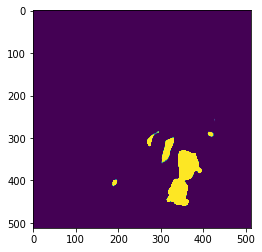

In [24]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('04.U-Net1_results_dir/101_predict.png')
imgplot = plt.imshow(img)
plt.show()

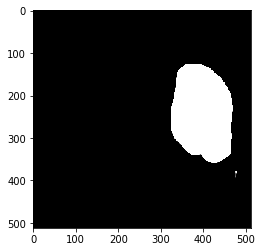

In [18]:
plt.imshow(np.squeeze(prediction[1]), cmap = "gray")

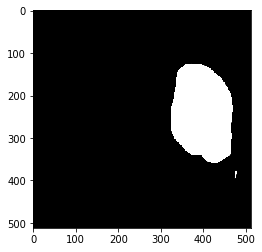

In [19]:
plt.imshow(np.squeeze(prediction[1]), cmap = "gray", vmin = 0.0, vmax= 0.09)

[[2.0629561e-01 9.0392336e-04 1.4742263e-05 ... 2.5926038e-05
  1.1089244e-03 1.4843126e-01]
 [9.3615276e-04 7.0756883e-08 5.1407722e-11 ... 8.8841184e-11
  7.9038657e-08 6.7879743e-04]
 [3.1334090e-05 1.7578129e-10 1.3664632e-14 ... 3.2751999e-14
  1.8978377e-10 2.2925035e-05]
 ...
 [1.0474886e-05 2.4142709e-11 5.0711376e-16 ... 3.5151362e-26
  2.3644186e-20 4.0212469e-11]
 [1.2426430e-03 7.6615073e-08 2.7319728e-11 ... 1.6932534e-18
  1.3631364e-14 7.4695684e-08]
 [1.5508819e-01 8.1716850e-04 9.4105335e-06 ... 1.7557596e-09
  2.0083732e-07 1.5457271e-03]]


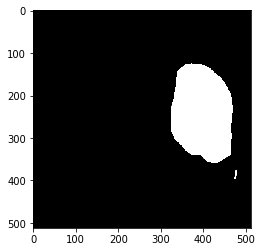

In [20]:
results_ =  np.squeeze(np.multiply(prediction[1], 255))
print(results_)

plt.imshow(results_, cmap = "gray", vmin = 0.0, vmax= 0.7)
plt.show()

Populating the interactive namespace from numpy and matplotlib


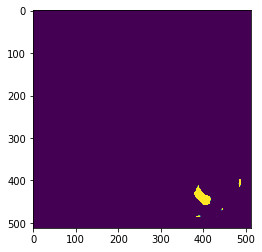

In [35]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('04.U-Net1_results_dir/35_predict.png')
imgplot = plt.imshow(img)
plt.show()

dict_keys(['val_mean_squared_error', 'val_precision', 'loss', 'val_Specificity', 'val_recall', 'acc', 'val_Sensitivity', 'val_f1score', 'precision', 'Specificity', 'f1score', 'recall', 'dice_coef', 'val_loss', 'val_acc', 'val_dice_coef', 'Jaccard_index', 'Sensitivity', 'val_Jaccard_index', 'mean_squared_error'])


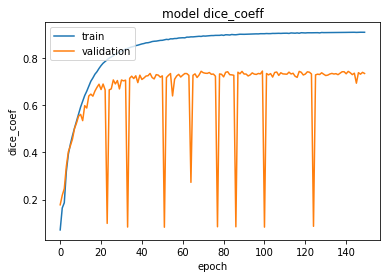

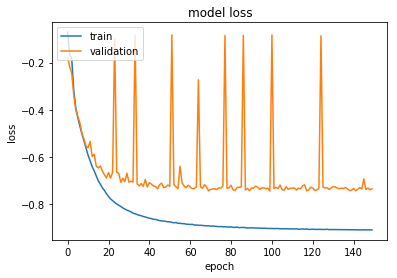

In [21]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('model dice_coeff')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()